In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

from textblob import TextBlob

from tqdm import tqdm_notebook as tqdm
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

C:\Users\HP\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\HP\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [2]:
df1 = pd.read_csv('kenya_tripadvisor_data_1.csv')
df1.head()

,Destination Name,Destination Type,Rating,Review Head,Review Body,Date
0,Giraffe Centre,Nature/Parks,5,Giraffes and Baby Elephants!,If you find yourself with a day in Nairobi bef...,June 2017
1,Giraffe Centre,Nature/Parks,4,Places to visit in Karen - Giraffe Centre,A fun place to visit - you not only get to fee...,December 2016
2,Giraffe Centre,Nature/Parks,3,Close to the giraffes,You get to come very close to the giraffes. Yo...,June 2017
3,Giraffe Centre,Nature/Parks,5,Giraffe kiss!,If you like giraffes you'll love this place. E...,June 2017
4,Giraffe Centre,Nature/Parks,5,A wonderful moment in time.,We always visit this attraction each and every...,June 2017


In [3]:
df2 = df1.copy()
df2.head()

,Destination Name,Destination Type,Rating,Review Head,Review Body,Date
0,Giraffe Centre,Nature/Parks,5,Giraffes and Baby Elephants!,If you find yourself with a day in Nairobi bef...,June 2017
1,Giraffe Centre,Nature/Parks,4,Places to visit in Karen - Giraffe Centre,A fun place to visit - you not only get to fee...,December 2016
2,Giraffe Centre,Nature/Parks,3,Close to the giraffes,You get to come very close to the giraffes. Yo...,June 2017
3,Giraffe Centre,Nature/Parks,5,Giraffe kiss!,If you like giraffes you'll love this place. E...,June 2017
4,Giraffe Centre,Nature/Parks,5,A wonderful moment in time.,We always visit this attraction each and every...,June 2017


In [4]:
from nltk import tokenize

df2.drop('Rating', axis = 1, inplace = True)
df2.drop('Date', axis = 1, inplace = True)
df2['Review Head'] = df2['Review Head'].apply(lambda x: re.sub('\s+', ' ', x))
df2['Review Body'] = df2['Review Body'].apply(lambda x: re.sub('\s+', ' ', x))
df2['RB_Sentence1'] = df2['Review Body'].apply(lambda x: tokenize.sent_tokenize(x)[0])
df2['RH_Split'] = df2['Review Head'].apply(lambda x: x.split(' '))
df2['RB_Split'] = df2['Review Body'].apply(lambda x: x.split(' '))
df2['RB_Sentence1_Split'] = df2['RB_Sentence1'].apply(lambda x: x.split(' '))
df2['TextBlob Polarity Head'] = df2['Review Head'].map(lambda text: TextBlob(text).sentiment.polarity)
df2['TextBlob Polarity Body'] = df2['Review Body'].map(lambda text: TextBlob(text).sentiment.polarity)
df2['TextBlob Polarity RBS1'] = df2['RB_Sentence1'].map(lambda text: TextBlob(text).sentiment.polarity)

In [5]:
df2.head()

,Destination Name,Destination Type,Review Head,Review Body,RB_Sentence1,RH_Split,RB_Split,RB_Sentence1_Split,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity RBS1
0,Giraffe Centre,Nature/Parks,Giraffes and Baby Elephants!,If you find yourself with a day in Nairobi bef...,If you find yourself with a day in Nairobi bef...,"[Giraffes, and, Baby, Elephants!]","[If, you, find, yourself, with, a, day, in, Na...","[If, you, find, yourself, with, a, day, in, Na...",0.0,0.160000,0.16
1,Giraffe Centre,Nature/Parks,Places to visit in Karen - Giraffe Centre,A fun place to visit - you not only get to fee...,A fun place to visit - you not only get to fee...,"[Places, to, visit, in, Karen, -, Giraffe, Cen...","[A, fun, place, to, visit, -, you, not, only, ...","[A, fun, place, to, visit, -, you, not, only, ...",0.0,0.450000,0.15
2,Giraffe Centre,Nature/Parks,Close to the giraffes,You get to come very close to the giraffes. Yo...,You get to come very close to the giraffes.,"[Close, to, the, giraffes]","[You, get, to, come, very, close, to, the, gir...","[You, get, to, come, very, close, to, the, gir...",0.0,0.100000,0.20
3,Giraffe Centre,Nature/Parks,Giraffe kiss!,If you like giraffes you'll love this place. E...,If you like giraffes you'll love this place.,"[Giraffe, kiss!]","[If, you, like, giraffes, you'll, love, this, ...","[If, you, like, giraffes, you'll, love, this, ...",0.0,0.200000,0.50
4,Giraffe Centre,Nature/Parks,A wonderful moment in time.,We always visit this attraction each and every...,We always visit this attraction each and every...,"[A, wonderful, moment, in, time.]","[We, always, visit, this, attraction, each, an...","[We, always, visit, this, attraction, each, an...",1.0,0.214286,0.00


In [6]:
df2['Destination Type'].value_counts()

Nature/Parks    21143
Museums          4685
Landmarks        3307
Name: Destination Type, dtype: int64

### Topic Modelling

In [7]:
# NLTK Stop words
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

test_subset = df2['RH_Split'].values
sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for value in test_subset:
    for word in value:
        if (sid.polarity_scores(word)['compound']) >= 0.4:
            pos_word_list.append(word)
        elif (sid.polarity_scores(word)['compound']) <= -0.4:
            print
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)                

print('Positive :', len(pos_word_list))       
print('Neutral :', len(neu_word_list))    
print('Negative :', len(neg_word_list))

Positive : 16736
Neutral : 112476
Negative : 618


In [8]:
from nltk.corpus import stopwords

# main_stop_words = ['ethiopia', 'ethiopian', 'rock', 'hewn', 'church', 'churches', 'park', 'parks', 'museum', 
#                        'museums', 'omo', 'valley', 'mountain', 'mountains', 'addis', 'ababa', 'lucy', 'simien', 
#                        'national', 'lalibela', 'gelada', 'haile', 'selassie', 'gondar', 'africa' , 'harar', 
#                        'cathedral', 'cathedrals', 'place', 'visit', 'girmay', 
#                        '\n', '‘s']

main_stop_words = ['kenya', 'kenyan', 'africa', 'african', 'church', 'churches', 'park', 'parks', 'museum', 'museums',
                   'lamu', 'valley', 'mountain', 'mountains', 'national', 'nairobi', 'amboseli'  
                   'cathedral', 'cathedrals', 'place', 'visit', 'site', 'town',  
                   '\n', '‘s']

positive_stop_words = list(set(pos_word_list))
negative_stop_words = list(set(neg_word_list))
total_stop_words = main_stop_words + positive_stop_words + negative_stop_words

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(total_stop_words)
print('Stop Words: ', len(stop_words))

Stop Words:  1493


In [9]:
# Convert to list
data = df2[df2['Destination Type'] == 'Landmarks'][df2['TextBlob Polarity Head'] > 0]['Review Head'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Okay place to visit']


In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['okay', 'place', 'to', 'visit']]


In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['okay', 'place', 'to', 'visit']


In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[[]]


In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[]]


In [15]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[]]

In [16]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [17]:
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.206*"old" + 0.078*"food" + 0.055*"time" + 0.047*"go" + 0.047*"spend" + '
  '0.035*"much" + 0.033*"architecture" + 0.024*"take" + 0.024*"set" + '
  '0.024*"part"'),
 (1,
  '0.273*"lunch" + 0.077*"stop" + 0.072*"point" + 0.043*"family" + '
  '0.037*"vantage" + 0.029*"quick" + 0.024*"whole" + 0.021*"dinner" + '
  '0.020*"drink" + 0.015*"wildlife"'),
 (2,
  '0.103*"really" + 0.070*"way" + 0.055*"farm" + 0.054*"tea" + 0.039*"culture" '
  '+ 0.031*"home" + 0.031*"tusk" + 0.028*"restaurant" + 0.026*"snake" + '
  '0.019*"eye"'),
 (3,
  '0.418*"view" + 0.033*"amboseli" + 0.027*"garden" + 0.025*"sunset" + '
  '0.020*"live" + 0.016*"stunning" + 0.015*"average" + 0.015*"degree" + '
  '0.014*"past" + 0.013*"close"'),
 (4,
  '0.115*"tour" + 0.114*"walk" + 0.089*"cheese" + 0.052*"coffee" + '
  '0.048*"location" + 0.045*"little" + 0.025*"new" + 0.020*"different" + '
  '0.016*"around" + 0.016*"outdoors"'),
 (5,
  '0.194*"history" + 0.039*"life" + 0.027*"historical" + 0.027*"expect" + '
  '0.0

In [18]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.8828754653087705

Coherence Score:  0.6603291593604277


In [19]:
# # Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

In [20]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
os.environ.update({'MALLET_HOME':r'C:/Users/HP/mallet-2.0.8/'})
mallet_path = r'C:\Users\HP\mallet-2.0.8\bin\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word, random_seed=1)

In [21]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('walk', 0.17727272727272728),
   ('farm', 0.06818181818181818),
   ('point', 0.05909090909090909),
   ('top', 0.045454545454545456),
   ('amboseli', 0.045454545454545456),
   ('short', 0.04090909090909091),
   ('full', 0.031818181818181815),
   ('viewpoint', 0.02727272727272727),
   ('hour', 0.02727272727272727),
   ('climb', 0.02727272727272727)]),
 (1,
  [('view', 0.606425702811245),
   ('staff', 0.020080321285140562),
   ('crocodile', 0.020080321285140562),
   ('sunset', 0.01606425702811245),
   ('stay', 0.01606425702811245),
   ('dining', 0.01606425702811245),
   ('refresh', 0.012048192771084338),
   ('date', 0.012048192771084338),
   ('cheap', 0.008032128514056224),
   ('lose', 0.008032128514056224)]),
 (2,
  [('time', 0.09302325581395349),
   ('cheese', 0.09302325581395349),
   ('animal', 0.06046511627906977),
   ('visit', 0.05581395348837209),
   ('city', 0.05116279069767442),
   ('magical', 0.037209302325581395),
   ('trip', 0.027906976744186046),
   ('restaurant', 0.0

2
3
4
5
6
7
8
9
10


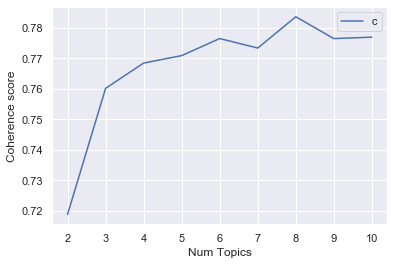

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word,
                                                random_seed=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

start1 = 2 
limit1 = 11
step1 = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start1, limit=limit1, step=step1)

x = range(start1, limit1, step1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.7188
Num Topics = 3  has Coherence Value of 0.7601
Num Topics = 4  has Coherence Value of 0.7684
Num Topics = 5  has Coherence Value of 0.7709
Num Topics = 6  has Coherence Value of 0.7765
Num Topics = 7  has Coherence Value of 0.7733
Num Topics = 8  has Coherence Value of 0.7836
Num Topics = 9  has Coherence Value of 0.7764
Num Topics = 10  has Coherence Value of 0.7769


In [26]:
optimal_model = model_list[6] # Number of Topics = 8

# optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=7, id2word=id2word)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.123*"history" + 0.083*"informative" + 0.079*"spot" + 0.058*"spend" + '
  '0.054*"make" + 0.047*"animal" + 0.047*"point" + 0.036*"restaurant" + '
  '0.029*"crocodile" + 0.025*"high"'),
 (1,
  '0.161*"day" + 0.122*"food" + 0.112*"trip" + 0.042*"guide" + 0.035*"quick" + '
  '0.028*"spot" + 0.024*"real" + 0.021*"live" + 0.017*"people" + 0.017*"feel"'),
 (2,
  '0.171*"tour" + 0.083*"walk" + 0.079*"cheese" + 0.079*"time" + '
  '0.056*"coffee" + 0.048*"set" + 0.024*"viewpoint" + 0.020*"average" + '
  '0.020*"food" + 0.020*"half"'),
 (3,
  '0.114*"view" + 0.059*"kid" + 0.055*"educational" + 0.040*"city" + '
  '0.037*"home" + 0.033*"cultural" + 0.033*"short" + 0.029*"magical" + '
  '0.026*"full" + 0.026*"part"'),
 (4,
  '0.268*"lunch" + 0.077*"family" + 0.063*"afternoon" + 0.059*"stop" + '
  '0.052*"location" + 0.038*"history" + 0.021*"famous" + 0.021*"scenery" + '
  '0.017*"collection" + 0.014*"shopping"'),
 (5,
  '0.216*"worth" + 0.061*"walk" + 0.051*"farm" + 0.037*"visit" + 0.037*"

In [27]:
optimal_model2 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model2, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.199913  0.161497       1        1  12.556971
0     -0.118615 -0.193090       2        1  12.541868
1     -0.140216  0.082461       3        1  12.525948
7      0.328255  0.088688       4        1  12.498011
6      0.018667 -0.240689       5        1  12.481986
4     -0.047857 -0.225067       6        1  12.475702
2     -0.150489  0.250996       7        1  12.472464
3      0.310168  0.075205       8        1  12.447049, topic_info=    Category        Freq           Term       Total  loglift  logprob
9    Default  174.000000           view  174.000000  30.0000  30.0000
2    Default   88.000000          lunch   88.000000  29.0000  29.0000
30   Default   76.000000     experience   76.000000  28.0000  28.0000
98   Default   72.000000          worth   72.000000  27.0000  27.0000
42   Default   56.000000           tour   56.000000  26.0000  26.0000
40   Default   54.000000            day   54.000000  25.0000  25.0000
26   Default   53.000000        history   53.000000  24.0000  24.0000
35   Default   47.000000           food   47.000000  23.0000  23.0000
38   Default   37.000000           trip   37.000000  22.0000  22.0000
25   Default   47.000000           walk   47.000000  21.0000  21.0000
206  Default   26.000000            tea   26.000000  20.0000  20.0000
120  Default   26.000000         cheese   26.000000  19.0000  19.0000
41   Default   29.000000    informative   29.000000  18.0000  18.0000
8    Default   35.000000           spot   35.000000  17.0000  17.0000
19   Default   25.000000         family   25.000000  16.0000  16.0000
111  Default   28.000000           time   28.000000  15.0000  15.0000
142  Default   20.000000      afternoon   20.000000  14.0000  14.0000
92   Default   19.000000           stop   19.000000  13.0000  13.0000
143  Default   19.000000          spend   19.000000  12.0000  12.0000
0    Default   18.000000         coffee   18.000000  11.0000  11.0000
61   Default   22.000000            kid   22.000000  10.0000  10.0000
227  Default   18.000000    educational   18.000000   9.0000   9.0000
324  Default   18.000000           make   18.000000   8.0000   8.0000
87   Default   17.000000       location   17.000000   7.0000   7.0000
11   Default   18.000000           farm   18.000000   6.0000   6.0000
81   Default   15.000000         animal   15.000000   5.0000   5.0000
224  Default   16.000000            set   16.000000   4.0000   4.0000
21   Default   16.000000          point   16.000000   3.0000   3.0000
29   Default   14.000000        culture   14.000000   2.0000   2.0000
52   Default   13.000000         garden   13.000000   1.0000   1.0000
..       ...         ...            ...         ...      ...      ...
7     Topic8   13.305576           city   13.305576   2.0837  -3.2116
128   Topic8   12.095979           home   12.095979   2.0837  -3.3069
60    Topic8    9.676783        magical    9.676783   2.0837  -3.5300
473   Topic8    8.467185           part    8.467185   2.0837  -3.6636
353   Topic8    6.047989            eat    6.047989   2.0837  -4.0000
231   Topic8    6.047989         dinner    6.047989   2.0837  -4.0000
484   Topic8    4.838391         dining    4.838391   2.0837  -4.2232
20    Topic8    4.838391      sundowner    4.838391   2.0837  -4.2232
618   Topic8    3.628794           roar    3.628794   2.0837  -4.5109
471   Topic8    3.628794  unforgettable    3.628794   2.0837  -4.5109
528   Topic8    3.628794           warm    3.628794   2.0837  -4.5109
531   Topic8    2.419196    improvement    2.419196   2.0837  -4.9163
670   Topic8    1.209598       touristy    1.209598   2.0837  -5.6095
455   Topic8    1.209598        glimpse    1.209598   2.0837  -5.6095
539   Topic8    1.209598        unusual    1.209598   2.0837  -5.6095
672   Topic8    1.209598       facality    1.209598   2.0837  -5.6095
534   Topic8    1.209598           wife    1.209598   2.0

In [28]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.1250,"history, informative, spot, spend, make, anima...",Okay place to visit
1,1,2.0,0.1422,"tour, walk, cheese, time, coffee, set, viewpoi...",Nice place to have a coffee
2,2,3.0,0.1334,"view, kid, educational, city, home, cultural, ...",This is a nice place if you maybee is danich o...
3,3,4.0,0.1422,"lunch, family, afternoon, stop, location, hist...",Great Lunch!
4,4,0.0,0.1250,"history, informative, spot, spend, make, anima...",Cool garden
5,5,5.0,0.1404,"worth, walk, farm, visit, meal, small, bird, c...",Poorly maintained park but good for bird watching
6,6,7.0,0.1487,"view, culture, garden, architecture, cool, set...",Amazing spot for a wide view of the city
7,7,5.0,0.1431,"worth, walk, farm, visit, meal, small, bird, c...","Interesting farm, overpriced restaurant"
8,8,6.0,0.1557,"experience, tea, amboseli, top, stunning, worl...","I really liked the place, it have everything t..."
9,9,0.0,0.1250,"history, informative, spot, spend, make, anima...",Nice place... but not for the crocodiles...


In [29]:
df_dominant_topic['Dominant_Topic'].value_counts()

0.0    835
7.0    177
4.0    167
1.0    157
2.0    145
3.0    143
6.0    138
5.0    135
Name: Dominant_Topic, dtype: int64

In [30]:
df_dominant_topic.to_csv('kenya_412.csv', index = False)

In [40]:
# import sys
# import numpy
# numpy.set_printoptions(threshold=sys.maxsize)

# Run 2

# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # Topicless/Unidentifiable - 835
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Food Appreciation - 157
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # Food Appreciation - 145
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # Visual Appreciation - 143
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # Food Appreciation - 167
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # Topicless/Unidentifiable - 135
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6]['Text'].values # History Appreciation - 138
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 7]['Text'].values # Visual Appreciation - 177

In [41]:
# import sys
# import numpy
# numpy.set_printoptions(threshold=sys.maxsize)

# Run 1

# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # General Appreciation - 876
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Commending Tour Organization - 210
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # Visual (Aesthetic, Scenery, etc.) - 188
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # History Appreciation - 177
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # Food Appreciation - 161 
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # General Appreciation - 126
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6]['Text'].values # Food Appreciation - 159

In [42]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1682,"history, informative, spot, spend, make, anima...",Wonderful buildings dating from the 16th century
1,1.0,0.1742,"day, food, trip, guide, quick, spot, real, liv...",Good to see the live and history of the englis...
2,2.0,0.1884,"tour, walk, cheese, time, coffee, set, viewpoi...",can not wait to try their new cheese flavored ...
3,3.0,0.1745,"view, kid, educational, city, home, cultural, ...","Warm, receptive and a home away from home"
4,4.0,0.1631,"lunch, family, afternoon, stop, location, hist...",A magical piece of richly diverse history
5,5.0,0.1724,"worth, walk, farm, visit, meal, small, bird, c...",old is gold with the prominent Anglican Church
6,6.0,0.1587,"experience, tea, amboseli, top, stunning, worl...",Interesting if you are familiar with story
7,7.0,0.1662,"view, culture, garden, architecture, cool, set...",Great lunch spot and incredible views as far a...


In [43]:
sent_topics_sorteddf_mallet['Text'].values

array(['Wonderful buildings dating from the 16th century',
       'Good to see the live and history of the english colonial people',
       'can not wait to try their new cheese flavored with coffee and honey',
       'Warm, receptive and a home away from home',
       'A magical piece of richly diverse history',
       'old is gold with the prominent Anglican Church',
       'Interesting if you are familiar with story',
       'Great lunch spot and incredible views as far as the eye can see'],
      dtype=object)

In [44]:
# # Number of Documents for Each Topic
# topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# # Percentage of Documents for Each Topic
# topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# # Topic Number and Keywords
# topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# # Concatenate Column wise
# df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# # Change Column names
# df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# # Show
# df_dominant_topics